# Unsupervised Learning Model

In [125]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

In [42]:
sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
symbols_list = sp500['Symbol'].unique().tolist()
print(symbols_list)

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BK', 'BBWI', 'BAX', 'BDX', 'BRK-B', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BX', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF-B', 'BLDR', 'BG', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CDAY', 'CF', 'CHRW', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CCI', 'CSX', 'CMI', 'C

In [43]:
end_date = '2024-01-01'
start_date = pd.to_datetime(end_date) - pd.DateOffset(years=8)

df = yf.download(
    tickers=symbols_list,
    start=start_date,
    end=end_date
)

[*********************100%%**********************]  503 of 503 completed


In [44]:
df = df.stack()
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()
df

adj close       close        high         low        open  \
date       ticker                                                               
2016-01-04 A        38.134441   40.689999   41.189999   40.340000   41.060001   
           AAL      39.095459   40.910000   41.349998   40.299999   41.290001   
           AAPL     23.977474   26.337500   26.342501   25.500000   25.652500   
           ABBV     40.392155   57.610001   58.320000   56.400002   58.060001   
           ABT      36.778629   42.930000   44.049999   42.500000   43.939999   
...                       ...         ...         ...         ...         ...   
2023-12-29 YUM     130.660004  130.660004  131.250000  130.210007  130.410004   
           ZBH     121.699997  121.699997  122.400002  121.239998  121.459999   
           ZBRA    273.329987  273.329987  276.309998  272.769989  274.730011   
           ZION     43.869999   43.869999   44.650002   43.720001   44.650002   
           ZTS     197.369995  197.369995  198.009995  196.250000  196.679993   

                        volume  
date       ticker               
2016-01-04 A         3287300.0  
           AAL      12037200.0  
           AAPL    270597600.0  
           ABBV     10308400.0  
           ABT      12227500.0  
...                        ...  
2023-12-29 YUM       1196800.0  
           ZBH        849600.0  
           ZBRA       251300.0  
           ZION      1420600.0  
           ZTS       1007200.0  

[994508 rows x 6 columns]

## Calculating the technical indicators for the stock market data:

### Garman Klass volatility and Bollinger Bands

adj close       close        high         low        open  \
date       ticker                                                               
2016-01-04 A        38.134441   40.689999   41.189999   40.340000   41.060001   
           AAL      39.095459   40.910000   41.349998   40.299999   41.290001   
           AAPL     23.977474   26.337500   26.342501   25.500000   25.652500   
           ABBV     40.392155   57.610001   58.320000   56.400002   58.060001   
           ABT      36.778629   42.930000   44.049999   42.500000   43.939999   
...                       ...         ...         ...         ...         ...   
2023-12-29 YUM     130.660004  130.660004  131.250000  130.210007  130.410004   
           ZBH     121.699997  121.699997  122.400002  121.239998  121.459999   
           ZBRA    273.329987  273.329987  276.309998  272.769989  274.730011   
           ZION     43.869999   43.869999   44.650002   43.720001   44.650002   
           ZTS     197.369995  197.369995  198.009995  196.250000  196.679993   

                        volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-01-04 A         3287300.0         -0.001893        NaN       NaN   
           AAL      12037200.0         -0.000821        NaN       NaN   
           AAPL    270597600.0         -0.001233        NaN       NaN   
           ABBV     10308400.0         -0.050297        NaN       NaN   
           ABT      12227500.0         -0.011585        NaN       NaN   
...                        ...               ...        ...       ...   
2023-12-29 YUM       1196800.0          0.000030  59.338371  4.824633   
           ZBH        849600.0          0.000044  68.767247  4.753563   
           ZBRA       251300.0          0.000073  67.914673  5.415905   
           ZION      1420600.0          0.000102  62.879829  3.611585   
           ZTS       1007200.0          0.000035  66.791335  5.186448   

                     bb_mid   bb_high  
date       ticker                      
2016-01-04 A            NaN       NaN  
           AAL          NaN       NaN  
           AAPL         NaN       NaN  
           ABBV         NaN       NaN  
           ABT          NaN       NaN  
...                     ...       ...  
2023-12-29 YUM     4.824633  4.824633  
           ZBH     4.753563  4.753563  
           ZBRA    5.415905  5.415905  
           ZION    3.611585  3.611585  
           ZTS     5.186448  5.186448  

[994508 rows x 11 columns]

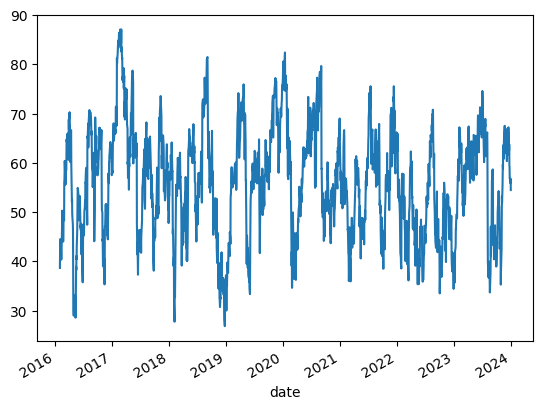

In [45]:
df['garman_klass_vol'] = ((np.log(df['high']) - np.log(df['low']))**2)/2 - (2*np.log(2)-1) * ((np.log(df['adj close']) - np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df.xs('AAPL', level=1)['rsi'].plot()

pandas_ta.bbands(close=df.xs('AAPL', level=1)['adj close'], length=20)
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 0])
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 0])
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 0])

df

### ATR of the stock

In [46]:
def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'], low=stock_data['low'], close=stock_data['close'], length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

df

adj close       close        high         low        open  \
date       ticker                                                               
2016-01-04 A        38.134441   40.689999   41.189999   40.340000   41.060001   
           AAL      39.095459   40.910000   41.349998   40.299999   41.290001   
           AAPL     23.977474   26.337500   26.342501   25.500000   25.652500   
           ABBV     40.392155   57.610001   58.320000   56.400002   58.060001   
           ABT      36.778629   42.930000   44.049999   42.500000   43.939999   
...                       ...         ...         ...         ...         ...   
2023-12-29 YUM     130.660004  130.660004  131.250000  130.210007  130.410004   
           ZBH     121.699997  121.699997  122.400002  121.239998  121.459999   
           ZBRA    273.329987  273.329987  276.309998  272.769989  274.730011   
           ZION     43.869999   43.869999   44.650002   43.720001   44.650002   
           ZTS     197.369995  197.369995  198.009995  196.250000  196.679993   

                        volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-01-04 A         3287300.0         -0.001893        NaN       NaN   
           AAL      12037200.0         -0.000821        NaN       NaN   
           AAPL    270597600.0         -0.001233        NaN       NaN   
           ABBV     10308400.0         -0.050297        NaN       NaN   
           ABT      12227500.0         -0.011585        NaN       NaN   
...                        ...               ...        ...       ...   
2023-12-29 YUM       1196800.0          0.000030  59.338371  4.824633   
           ZBH        849600.0          0.000044  68.767247  4.753563   
           ZBRA       251300.0          0.000073  67.914673  5.415905   
           ZION      1420600.0          0.000102  62.879829  3.611585   
           ZTS       1007200.0          0.000035  66.791335  5.186448   

                     bb_mid   bb_high       atr  
date       ticker                                
2016-01-04 A            NaN       NaN       NaN  
           AAL          NaN       NaN       NaN  
           AAPL         NaN       NaN       NaN  
           ABBV         NaN       NaN       NaN  
           ABT          NaN       NaN       NaN  
...                     ...       ...       ...  
2023-12-29 YUM     4.824633  4.824633 -0.073239  
           ZBH     4.753563  4.753563 -1.054422  
           ZBRA    5.415905  5.415905 -0.154931  
           ZION    3.611585  3.611585  0.177122  
           ZTS     5.186448  5.186448  0.420520  

[994508 rows x 12 columns]

### MACD of the stock

In [47]:
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:, 0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].transform(compute_macd)
df

adj close       close        high         low        open  \
date       ticker                                                               
2016-01-04 A        38.134441   40.689999   41.189999   40.340000   41.060001   
           AAL      39.095459   40.910000   41.349998   40.299999   41.290001   
           AAPL     23.977474   26.337500   26.342501   25.500000   25.652500   
           ABBV     40.392155   57.610001   58.320000   56.400002   58.060001   
           ABT      36.778629   42.930000   44.049999   42.500000   43.939999   
...                       ...         ...         ...         ...         ...   
2023-12-29 YUM     130.660004  130.660004  131.250000  130.210007  130.410004   
           ZBH     121.699997  121.699997  122.400002  121.239998  121.459999   
           ZBRA    273.329987  273.329987  276.309998  272.769989  274.730011   
           ZION     43.869999   43.869999   44.650002   43.720001   44.650002   
           ZTS     197.369995  197.369995  198.009995  196.250000  196.679993   

                        volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-01-04 A         3287300.0         -0.001893        NaN       NaN   
           AAL      12037200.0         -0.000821        NaN       NaN   
           AAPL    270597600.0         -0.001233        NaN       NaN   
           ABBV     10308400.0         -0.050297        NaN       NaN   
           ABT      12227500.0         -0.011585        NaN       NaN   
...                        ...               ...        ...       ...   
2023-12-29 YUM       1196800.0          0.000030  59.338371  4.824633   
           ZBH        849600.0          0.000044  68.767247  4.753563   
           ZBRA       251300.0          0.000073  67.914673  5.415905   
           ZION      1420600.0          0.000102  62.879829  3.611585   
           ZTS       1007200.0          0.000035  66.791335  5.186448   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2016-01-04 A            NaN       NaN       NaN       NaN  
           AAL          NaN       NaN       NaN       NaN  
           AAPL         NaN       NaN       NaN       NaN  
           ABBV         NaN       NaN       NaN       NaN  
           ABT          NaN       NaN       NaN       NaN  
...                     ...       ...       ...       ...  
2023-12-29 YUM     4.824633  4.824633 -0.073239  0.784240  
           ZBH     4.753563  4.753563 -1.054422  0.973531  
           ZBRA    5.415905  5.415905 -0.154931  1.577769  
           ZION    3.611585  3.611585  0.177122  2.099563  
           ZTS     5.186448  5.186448  0.420520  2.164720  

[994508 rows x 13 columns]

### Dollar Volume

In [48]:
df['dollar volume'] = (df['adj close']*df['volume'])/1e6
df

adj close       close        high         low        open  \
date       ticker                                                               
2016-01-04 A        38.134441   40.689999   41.189999   40.340000   41.060001   
           AAL      39.095459   40.910000   41.349998   40.299999   41.290001   
           AAPL     23.977474   26.337500   26.342501   25.500000   25.652500   
           ABBV     40.392155   57.610001   58.320000   56.400002   58.060001   
           ABT      36.778629   42.930000   44.049999   42.500000   43.939999   
...                       ...         ...         ...         ...         ...   
2023-12-29 YUM     130.660004  130.660004  131.250000  130.210007  130.410004   
           ZBH     121.699997  121.699997  122.400002  121.239998  121.459999   
           ZBRA    273.329987  273.329987  276.309998  272.769989  274.730011   
           ZION     43.869999   43.869999   44.650002   43.720001   44.650002   
           ZTS     197.369995  197.369995  198.009995  196.250000  196.679993   

                        volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-01-04 A         3287300.0         -0.001893        NaN       NaN   
           AAL      12037200.0         -0.000821        NaN       NaN   
           AAPL    270597600.0         -0.001233        NaN       NaN   
           ABBV     10308400.0         -0.050297        NaN       NaN   
           ABT      12227500.0         -0.011585        NaN       NaN   
...                        ...               ...        ...       ...   
2023-12-29 YUM       1196800.0          0.000030  59.338371  4.824633   
           ZBH        849600.0          0.000044  68.767247  4.753563   
           ZBRA       251300.0          0.000073  67.914673  5.415905   
           ZION      1420600.0          0.000102  62.879829  3.611585   
           ZTS       1007200.0          0.000035  66.791335  5.186448   

                     bb_mid   bb_high       atr      macd  dollar volume  
date       ticker                                                         
2016-01-04 A            NaN       NaN       NaN       NaN     125.359349  
           AAL          NaN       NaN       NaN       NaN     470.599859  
           AAPL         NaN       NaN       NaN       NaN    6488.246976  
           ABBV         NaN       NaN       NaN       NaN     416.378487  
           ABT          NaN       NaN       NaN       NaN     449.710690  
...                     ...       ...       ...       ...            ...  
2023-12-29 YUM     4.824633  4.824633 -0.073239  0.784240     156.373892  
           ZBH     4.753563  4.753563 -1.054422  0.973531     103.396317  
           ZBRA    5.415905  5.415905 -0.154931  1.577769      68.687826  
           ZION    3.611585  3.611585  0.177122  2.099563      62.321720  
           ZTS     5.186448  5.186448  0.420520  2.164720     198.791059  

[994508 rows x 14 columns]

## Converting daily data to monthly data

In [69]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar volume', 'volume', 'open', 'high', 'low', 'close']]
last_cols
data = (pd.concat([df.unstack('ticker')['dollar volume'].resample('M').mean().stack('ticker').to_frame('dollar volume'),
    df.unstack()[last_cols].resample('M').last().stack('ticker')], axis=1)).dropna()

data

dollar volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2016-02-29 A           91.918051   35.004200         -0.001914  48.107889   
           AAL        338.977827   39.288376         -0.000319  56.664347   
           AAPL      3548.073934   22.125885         -0.003013  48.335941   
           ABBV       353.627758   38.690899         -0.051766  47.896376   
           ABT        244.683668   33.398449         -0.009964  47.034959   
...                          ...         ...               ...        ...   
2023-12-31 YUM        207.539266  130.660004          0.000030  59.338371   
           ZBH        207.682671  121.699997          0.000044  68.767247   
           ZBRA        98.037275  273.329987          0.000073  67.914673   
           ZION       102.724363   43.869999          0.000102  62.879829   
           ZTS        335.154638  197.369995          0.000035  66.791335   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2016-02-29 A       3.522492  3.522492  3.522492 -0.932886 -0.240045  
           AAL     3.547833  3.547833  3.547833  0.977081  0.529240  
           AAPL    3.106253  3.106253  3.106253 -1.017466 -0.330066  
           ABBV    3.629341  3.629341  3.629341 -0.477602 -0.288564  
           ABT     3.479070  3.479070  3.479070 -0.797320 -0.394515  
...                     ...       ...       ...       ...       ...  
2023-12-31 YUM     4.824633  4.824633  4.824633 -0.073239  0.784240  
           ZBH     4.753563  4.753563  4.753563 -1.054422  0.973531  
           ZBRA    5.415905  5.415905  5.415905 -0.154931  1.577769  
           ZION    3.611585  3.611585  3.611585  0.177122  2.099563  
           ZTS     5.186448  5.186448  5.186448  0.420520  2.164720  

[46953 rows x 9 columns]

Filter out top 150 stocks based on dollar volume

In [70]:
data['dollar volume'] = (data.loc[:, 'dollar volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar volume rank'] = (data.groupby('date')['dollar volume'].rank(ascending=False))
data

data = data[data['dollar volume rank']<150].drop(['dollar volume rank', 'dollar volume'], axis=1)
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-01-31 AAL      42.760246         -0.000522  42.277609  3.789144   
           AAPL     28.233549         -0.001885  67.547800  3.332440   
           ABBV     44.951488         -0.031911  49.245587  3.805577   
           ABT      36.922546         -0.003303  66.810976  3.572445   
           ACN     101.850822         -0.004805  41.080231  4.634323   
...                       ...               ...        ...       ...   
2023-12-31 VRTX    406.890015          0.000028  65.899356  5.817492   
           VZ       37.074799          0.000043  57.985178  3.616386   
           WFC      49.220001          0.000025  67.347850  3.800094   
           WMT     157.649994          0.000017  52.372668  5.018094   
           XOM      99.980003          0.000041  42.607132  4.594084   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2017-01-31 AAL     3.789144  3.789144  1.295678 -0.163933  
           AAPL    3.332440  3.332440 -1.191554 -0.108144  
           ABBV    3.805577  3.805577 -1.207862 -0.322386  
           ABT     3.572445  3.572445 -1.167994  0.206063  
           ACN     4.634323  4.634323 -1.021878 -0.450311  
...                     ...       ...       ...       ...  
2023-12-31 VRTX    5.817492  5.817492  1.086119  3.205584  
           VZ      3.616386  3.616386 -1.182997  0.466399  
           WFC     3.800094  3.800094 -0.753985  1.913446  
           WMT     5.018094  5.018094 -0.005190 -0.274379  
           XOM     4.594084  4.594084  0.072672 -0.683288  

[12516 rows x 8 columns]

## Calculate monthly returns for different time horizons

In [71]:
def calculate_returns(df):

    outlier_cutoff = 0.005
    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:
        df[f'return_{lag}m'] = df['adj close'].pct_change(lag).pipe(lambda x: x.clip(
            lower=x.quantile(outlier_cutoff),
            upper=x.quantile(1-outlier_cutoff))).add(1).pow(1/lag).sub(1)
        
    return df


data = data.groupby('ticker', group_keys=False).apply(calculate_returns).dropna()
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2018-01-31 AAL      52.943863          0.000502  53.332147  3.908840   
           AAPL     39.581039         -0.001000  40.100582  3.700759   
           ABBV     85.312195         -0.035857  62.305762  4.262649   
           ABT      56.127323         -0.004576  69.274936  3.951524   
           ACN     146.635666         -0.002948  63.135409  4.964963   
...                       ...               ...        ...       ...   
2023-12-31 VRTX    406.890015          0.000028  65.899356  5.817492   
           VZ       37.074799          0.000043  57.985178  3.616386   
           WFC      49.220001          0.000025  67.347850  3.800094   
           WMT     157.649994          0.000017  52.372668  5.018094   
           XOM      99.980003          0.000041  42.607132  4.594084   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2018-01-31 AAL     3.908840  3.908840  1.275944  0.617049   0.044013   
           AAPL    3.700759  3.700759 -0.960483 -0.414727  -0.010636   
           ABBV    4.262649  4.262649  1.476496  2.091141   0.168700   
           ABT     3.951524  3.951524 -0.696011  0.975508   0.094398   
           ACN     4.964963  4.964963 -0.984613  0.293257   0.049710   
...                     ...       ...       ...       ...        ...   
2023-12-31 VRTX    5.817492  5.817492  1.086119  3.205584   0.146783   
           VZ      3.616386  3.616386 -1.182997  0.466399  -0.016436   
           WFC     3.800094  3.800094 -0.753985  1.913446   0.103835   
           WMT     5.018094  5.018094 -0.005190 -0.274379   0.016350   
           XOM     4.594084  4.594084  0.072672 -0.683288  -0.026864   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-01-31 AAL      0.037235   0.051541   0.013139   0.028045    0.017961  
           AAPL    -0.012944  -0.001992   0.021212   0.018481    0.028553  
           ABBV     0.079893   0.077893   0.081693   0.063580    0.054846  
           ABT      0.052610   0.048209   0.041483   0.041095    0.035516  
           ACN      0.041987   0.041220   0.039210   0.032852    0.030836  
...                      ...        ...        ...        ...         ...  
2023-12-31 VRTX     0.060030   0.053758   0.024490   0.028824    0.028985  
           VZ       0.035933   0.055029   0.008786   0.002693    0.002233  
           WFC      0.117430   0.067168   0.026895   0.033852    0.017357  
           WMT     -0.015960  -0.003544   0.001708   0.008697    0.010148  
           XOM     -0.023690  -0.049736  -0.008782  -0.007363   -0.005374  

[10343 rows x 14 columns]

## Downloading Fama-French factors and calculate rolling factor betas

In [79]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start=2010)[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data.xs('AAPL', level=1).head()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
date,,,,,,
2018-01-31,0.0557,-0.0318,-0.0129,-0.0076,-0.0096,-0.010636
2018-02-28,-0.0365,0.0032,-0.0104,0.0052,-0.0237,0.068185
2018-03-31,-0.0235,0.0359,-0.0021,-0.0046,0.0001,-0.058051
2018-04-30,0.0028,0.0093,0.0054,-0.0242,0.0130,-0.015020
2018-05-31,0.0265,0.0473,-0.0320,-0.0204,-0.0150,0.135124


### Filter out stocks with less than 10 months of data

In [80]:
observations = factor_data.groupby(level=1).size()
valid_stocks = observations[observations >= 10]
valid_stocks
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-01-31 AAL     0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.044013
           AAPL    0.0557 -0.0318 -0.0129 -0.0076 -0.0096  -0.010636
           ABBV    0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.168700
           ABT     0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.094398
           ACN     0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.049710
...                   ...     ...     ...     ...     ...        ...
2023-11-30 VRTX    0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.020160
           VZ      0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.091090
           WFC     0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.131192
           WMT     0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.047243
           XOM     0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.020506

[10146 rows x 6 columns]

## Calculate rolling factor betas

In [86]:
betas = factor_data.groupby(level=1, group_keys=False).apply(lambda x: RollingOLS(
    endog=x['return_1m'], exog=sm.add_constant(x.drop('return_1m', axis=1)),
    window=min(24, x.shape[0]), min_nobs=len(x.columns) + 1
).fit(params_only=True).params.drop('const', axis=1))
betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-01-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-11-30 VRTX    0.376280 -0.326575 -0.445064  0.318978  0.869254
           VZ      0.444390 -0.662956  0.517152  0.210201 -0.205924
           WFC     1.037897  0.401001  2.011853 -0.363960 -1.477538
           WMT     0.497263  0.081987 -0.730999  0.577486  0.752984
           XOM     0.722589 -0.210770  1.202657  0.229340  0.172209

[10146 rows x 5 columns]

In [91]:
data = data.join(betas.groupby('ticker').shift())
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))
data

data = data.drop('adj close', axis=1)

data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10343 entries, (Timestamp('2018-01-31 00:00:00'), 'AAL') to (Timestamp('2023-12-31 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10343 non-null  float64
 1   rsi               10343 non-null  float64
 2   bb_low            10343 non-null  float64
 3   bb_mid            10343 non-null  float64
 4   bb_high           10343 non-null  float64
 5   atr               10343 non-null  float64
 6   macd              10343 non-null  float64
 7   return_1m         10343 non-null  float64
 8   return_2m         10343 non-null  float64
 9   return_3m         10343 non-null  float64
 10  return_6m         10343 non-null  float64
 11  return_9m         10343 non-null  float64
 12  return_12m        10343 non-null  float64
 13  Mkt-RF            10145 non-null  float64
 14  SMB               10145 non-null  float64
 15  HML        

# Fitting a K-Means Cluster Algorithm

In [110]:
from sklearn.cluster import KMeans

data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)
data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2018-01-31 AAL             0.000502  53.332147  3.908840  3.908840  3.908840   
           AAPL           -0.001000  40.100582  3.700759  3.700759  3.700759   
           ABBV           -0.035857  62.305762  4.262649  4.262649  4.262649   
           ABT            -0.004576  69.274936  3.951524  3.951524  3.951524   
           ACN            -0.002948  63.135409  4.964963  4.964963  4.964963   
...                             ...        ...       ...       ...       ...   
2023-12-31 VRTX            0.000028  65.899356  5.817492  5.817492  5.817492   
           VZ              0.000043  57.985178  3.616386  3.616386  3.616386   
           WFC             0.000025  67.347850  3.800094  3.800094  3.800094   
           WMT             0.000017  52.372668  5.018094  5.018094  5.018094   
           XOM             0.000041  42.607132  4.594084  4.594084  4.594084   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2018-01-31 AAL     1.275944  0.617049   0.044013   0.037235   0.051541   
           AAPL   -0.960483 -0.414727  -0.010636  -0.012944  -0.001992   
           ABBV    1.476496  2.091141   0.168700   0.079893   0.077893   
           ABT    -0.696011  0.975508   0.094398   0.052610   0.048209   
           ACN    -0.984613  0.293257   0.049710   0.041987   0.041220   
...                     ...       ...        ...        ...        ...   
2023-12-31 VRTX    1.086119  3.205584   0.146783   0.060030   0.053758   
           VZ     -1.182997  0.466399  -0.016436   0.035933   0.055029   
           WFC    -0.753985  1.913446   0.103835   0.117430   0.067168   
           WMT    -0.005190 -0.274379   0.016350  -0.015960  -0.003544   
           XOM     0.072672 -0.683288  -0.026864  -0.023690  -0.049736   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-01-31 AAL      0.013139   0.028045    0.017961  1.249866  1.364709   
           AAPL     0.021212   0.018481    0.028553  1.309647 -0.322088   
           ABBV     0.081693   0.063580    0.054846  0.471598  0.471135   
           ABT      0.041483   0.041095    0.035516  0.817002 -0.161575   
           ACN      0.039210   0.032852    0.030836  1.214378 -0.164183   
...                      ...        ...         ...       ...       ...   
2023-12-31 VRTX     0.024490   0.028824    0.028985  0.525011  0.001544   
           VZ       0.008786   0.002693    0.002233  0.488888 -0.360819   
           WFC      0.026895   0.033852    0.017357  1.076098 -0.094078   
           WMT      0.001708   0.008697    0.010148  0.610658 -0.446031   
           XOM     -0.008782  -0.007363   -0.005374  1.138797  0.273601   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-01-31 AAL     0.550423  0.308895  0.674377        1  
           AAPL   -0.616277  0.569705  0.568891        0  
           ABBV   -0.092797  0.370261  0.262703        2  
           ABT    -0.518633  0.287617  0.988573        3  
           ACN    -0.309567  0.294672  0.177458        2  
...                     ...       ...       ...      ...  
2023-12-31 VRTX   -0.906215  0.132005  0.860918        0  
           VZ      0.085436  0.291999  0.474503        2  
           WFC     1.438222 -0.732211 -0.616143        0  
           WMT    -0.313553  0.315892  0.700380        2  
           XOM     0.675689 -0.489316  0.647678        1  

[10145 rows x 19 columns]

In [111]:
def plot_clusters(data):
    cluster_0 = data[data['cluster'] == 0]
    cluster_1 = data[data['cluster'] == 1]
    cluster_2 = data[data['cluster'] == 2]
    cluster_3 = data[data['cluster'] == 3]
    
    plt.scatter(cluster_0.iloc[:, 5], cluster_0.iloc[:, 1], color='red', label='Cluster 0')
    plt.scatter(cluster_1.iloc[:, 5], cluster_1.iloc[:, 1], color='blue', label='Cluster 1')
    plt.scatter(cluster_2.iloc[:, 5], cluster_2.iloc[:, 1], color='green', label='Cluster 2')
    plt.scatter(cluster_3.iloc[:, 5], cluster_3.iloc[:, 1], color='yellow', label='Cluster 3')
    
    plt.legend()
    plt.show()
    return

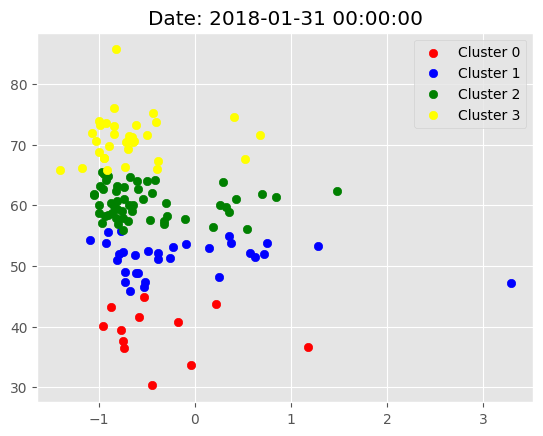

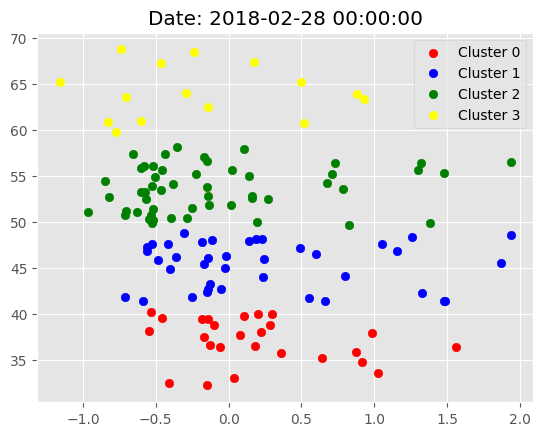

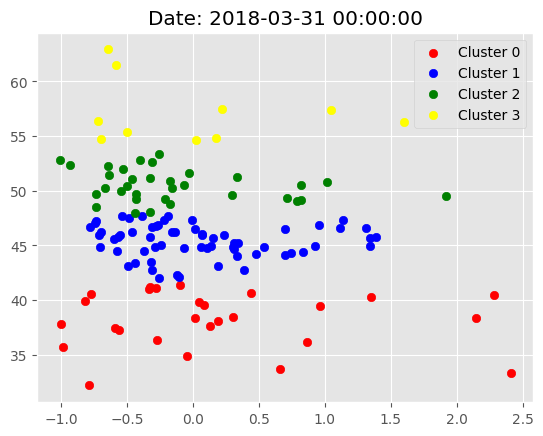

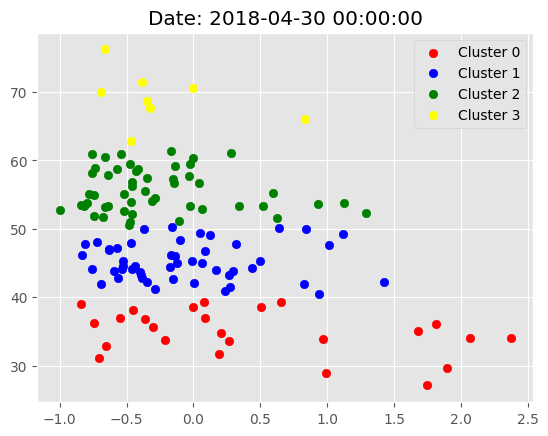

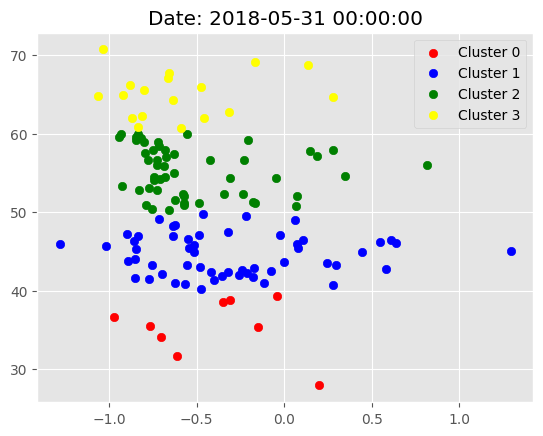

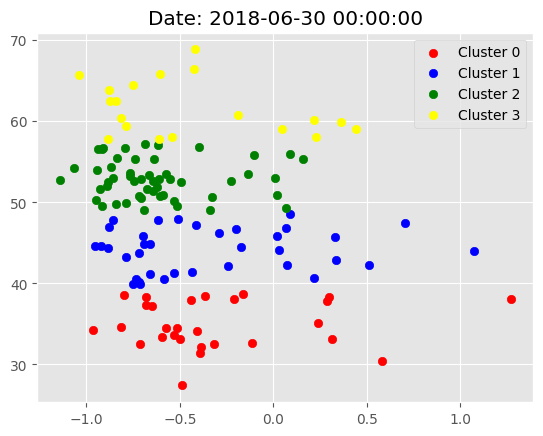

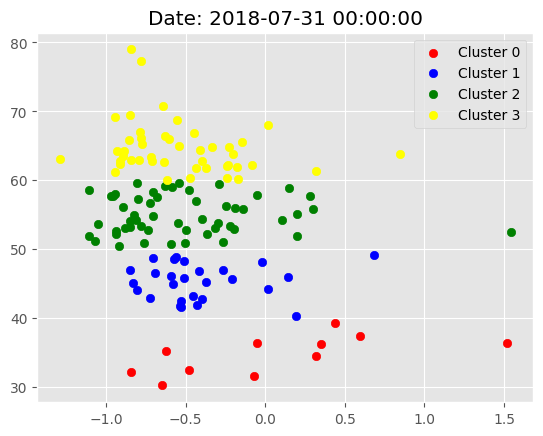

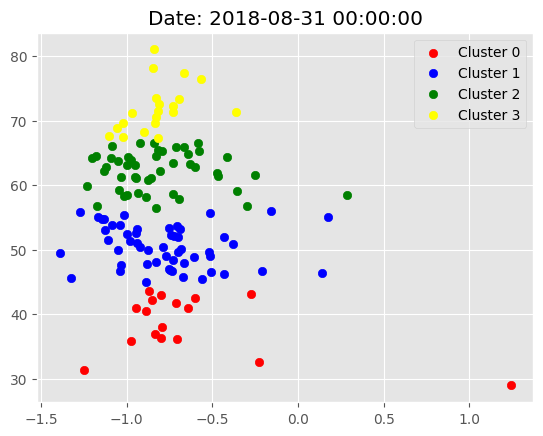

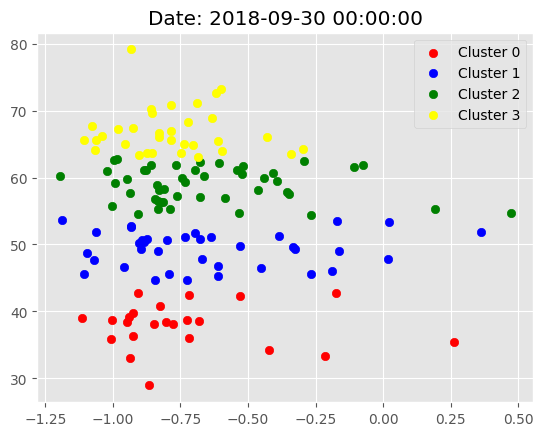

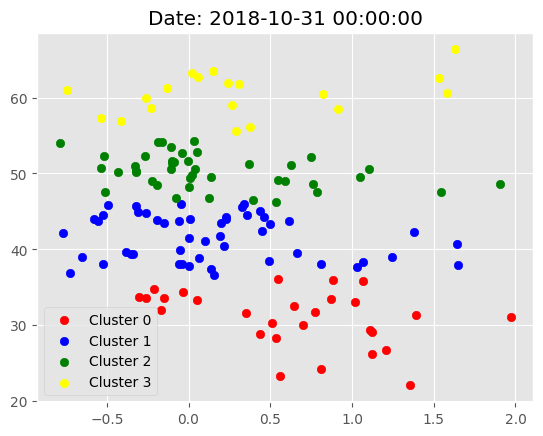

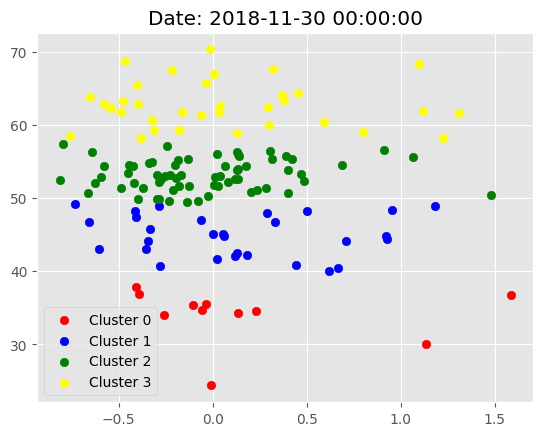

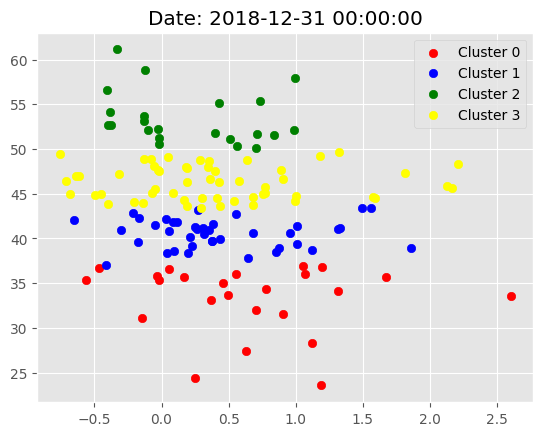

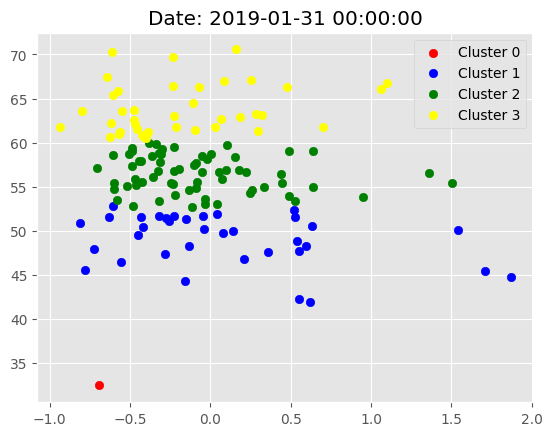

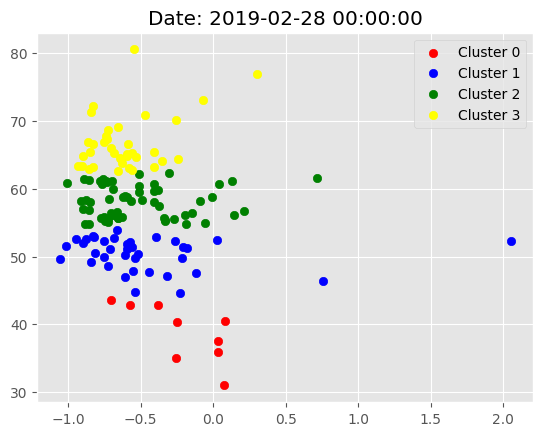

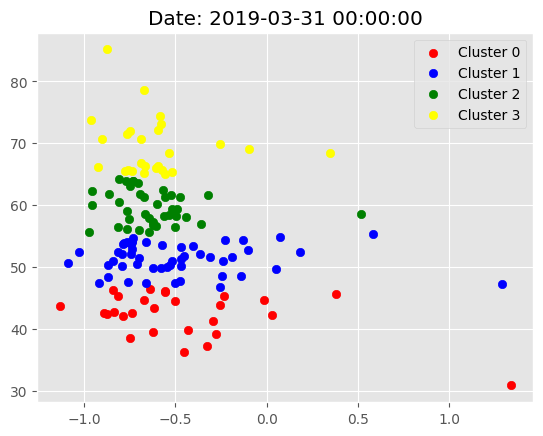

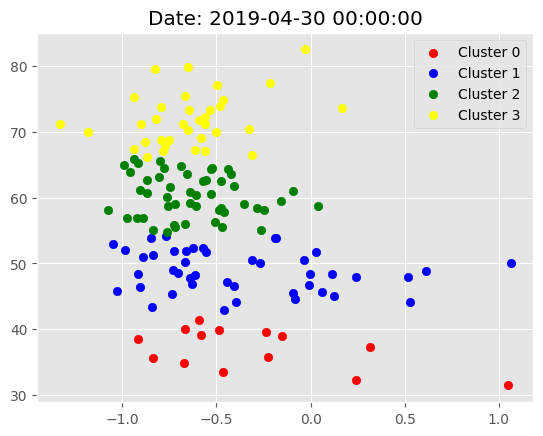

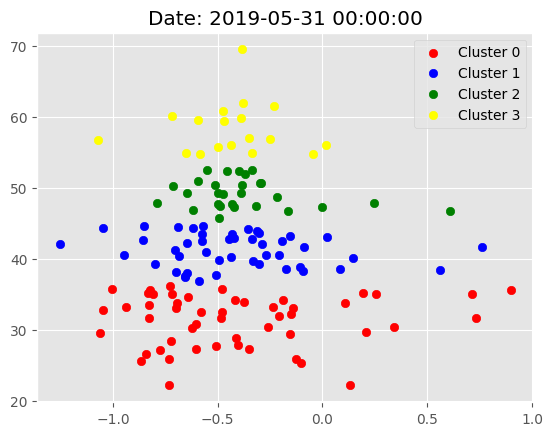

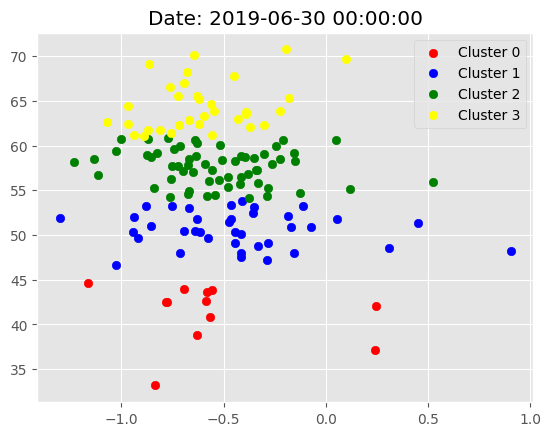

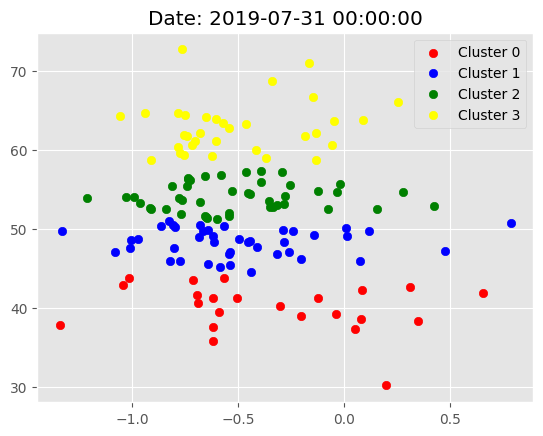

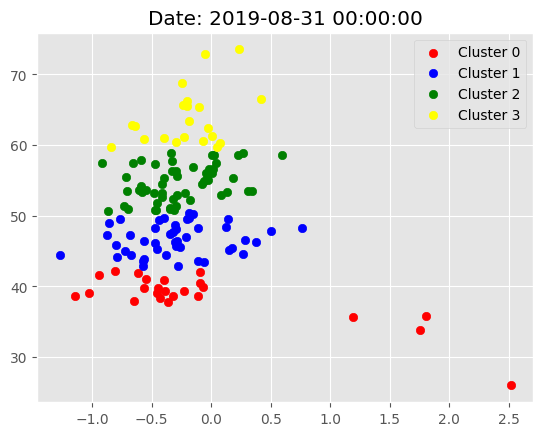

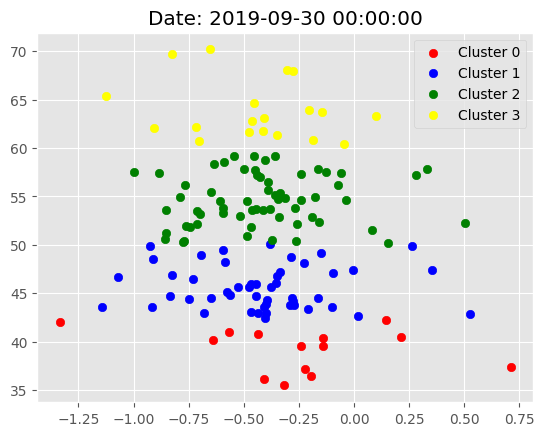

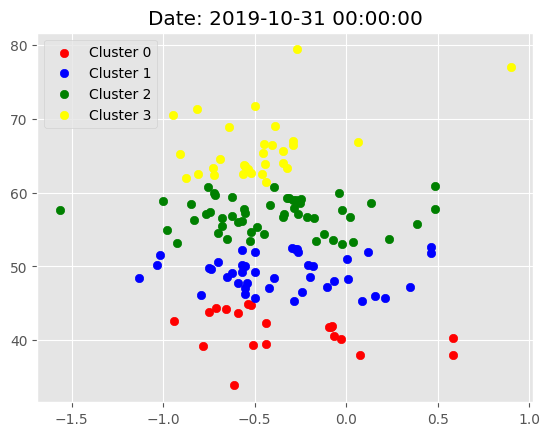

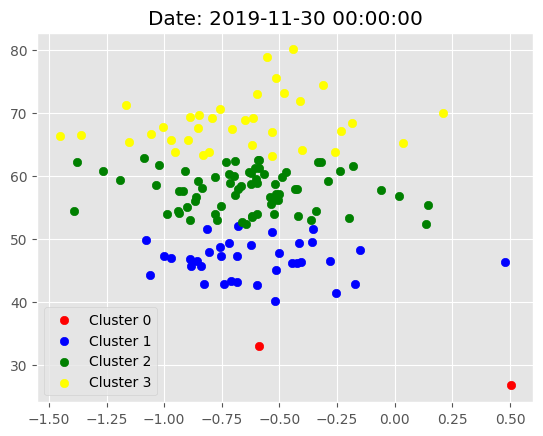

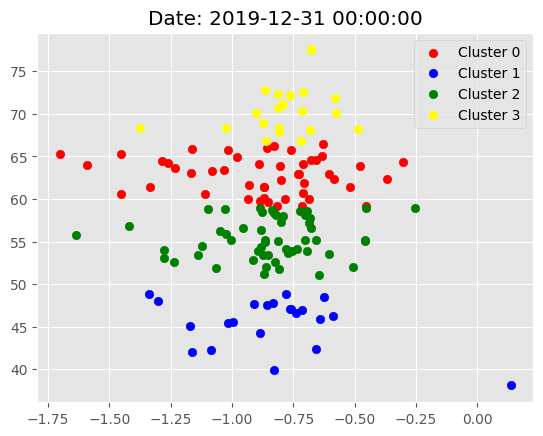

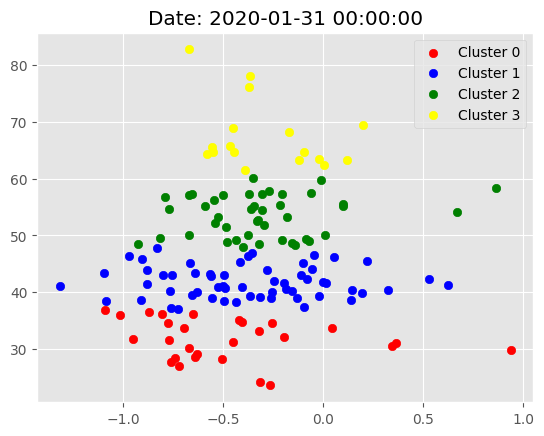

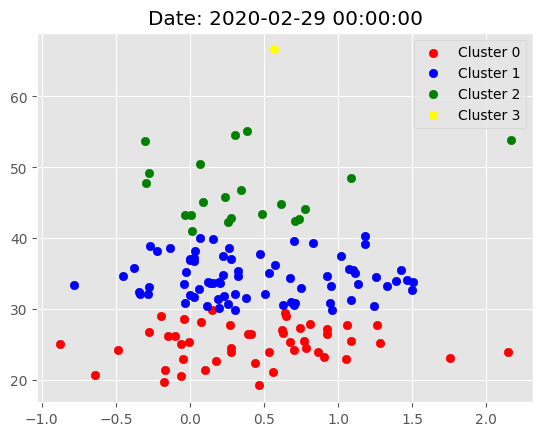

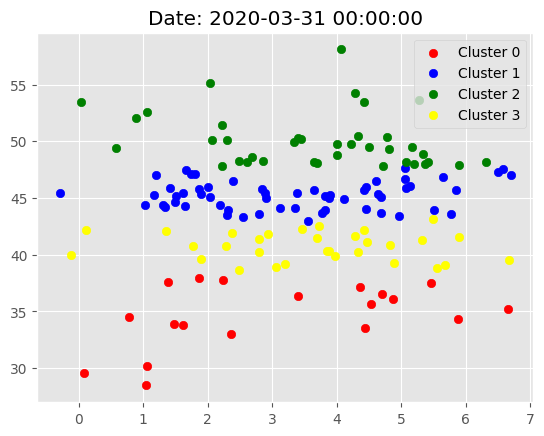

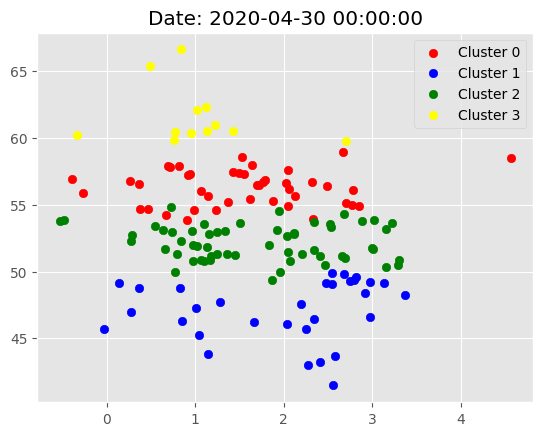

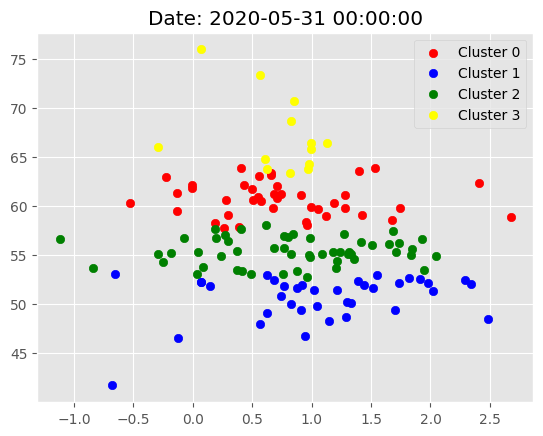

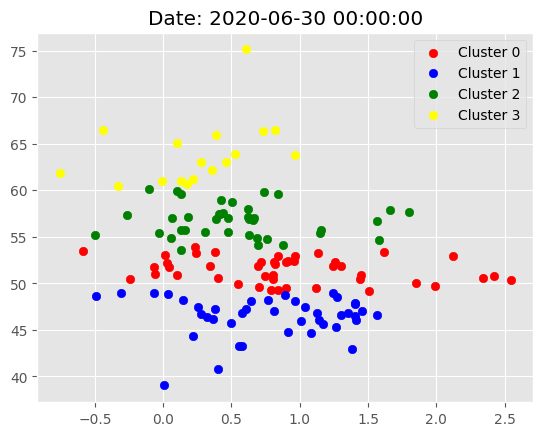

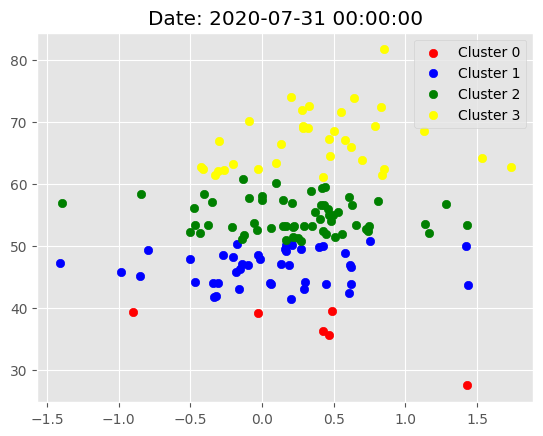

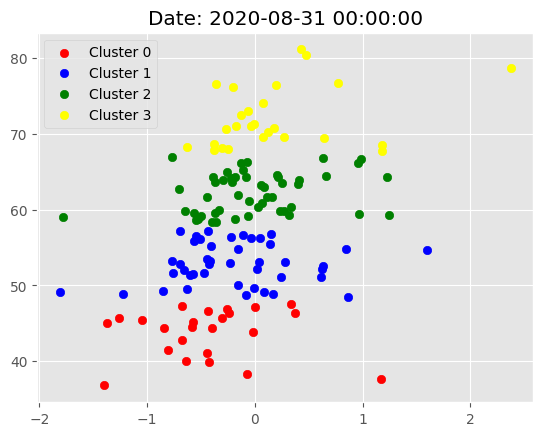

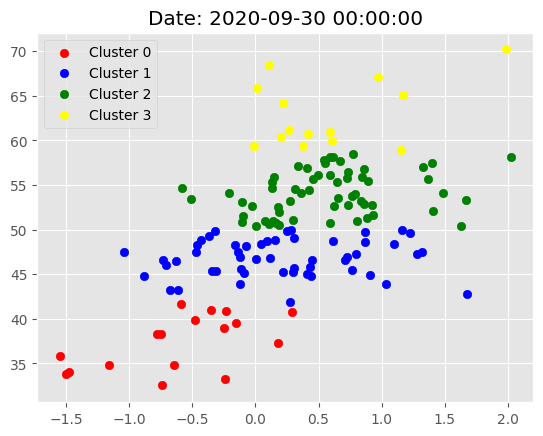

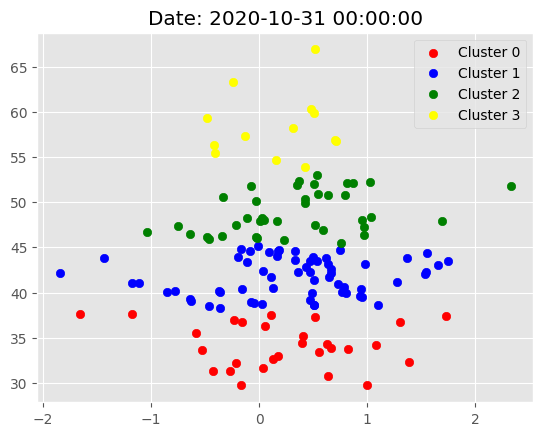

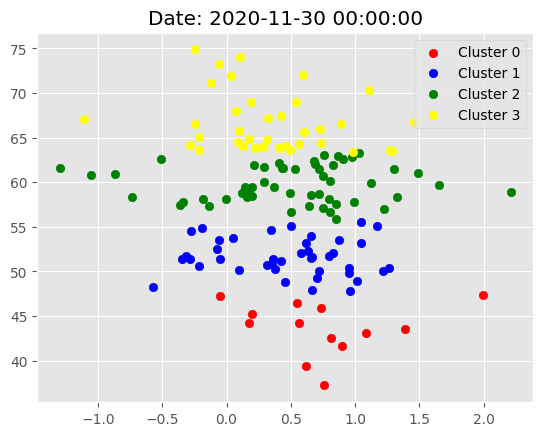

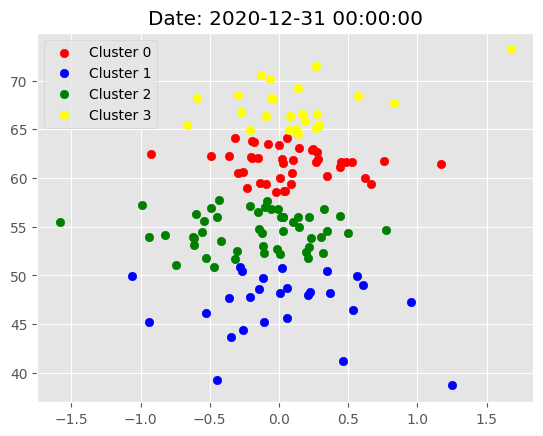

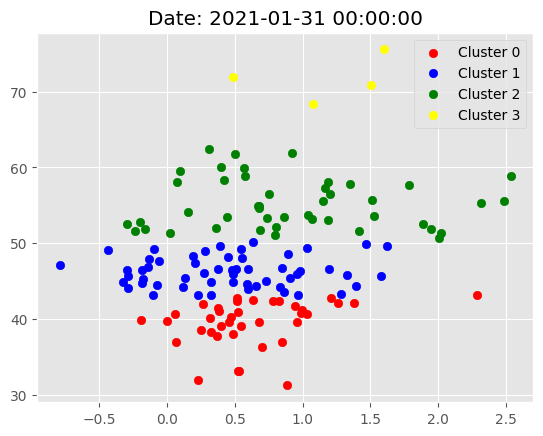

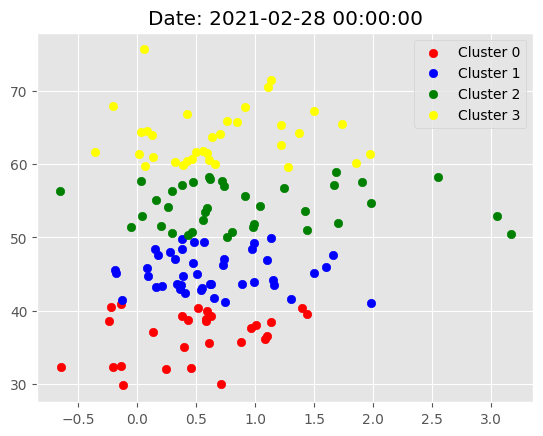

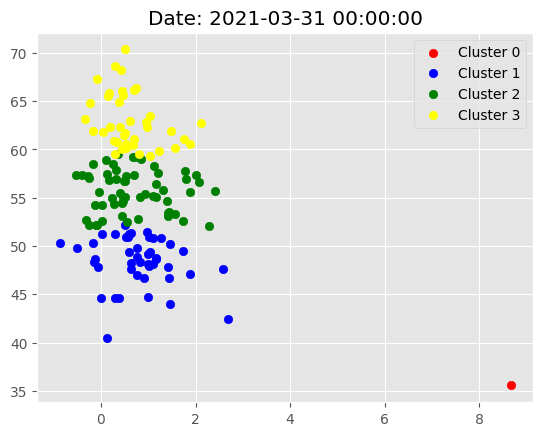

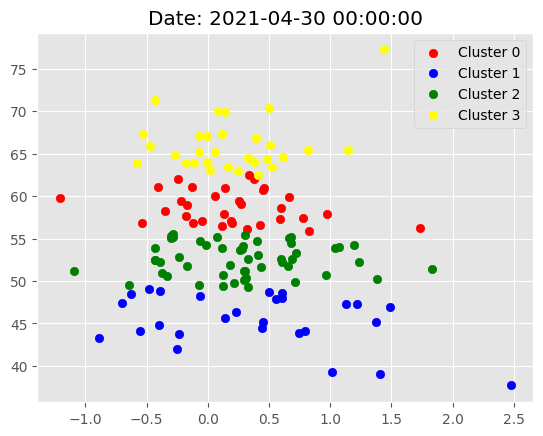

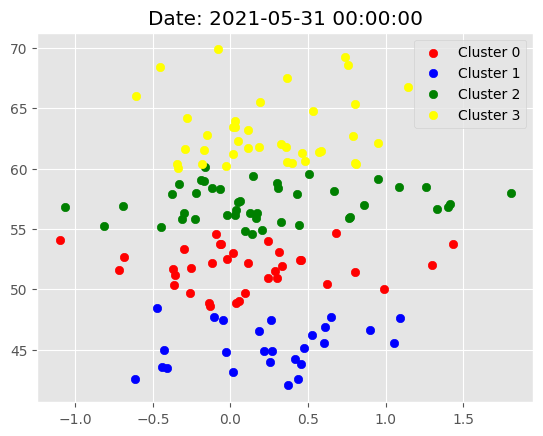

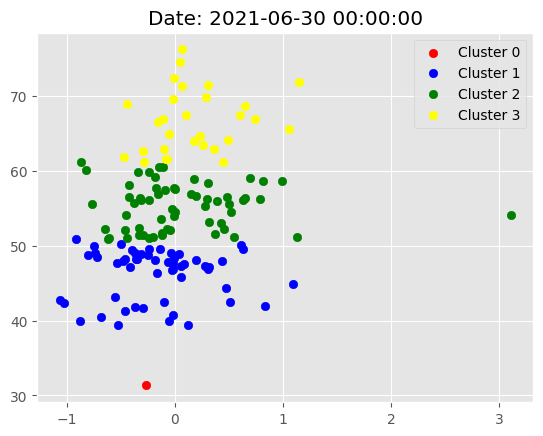

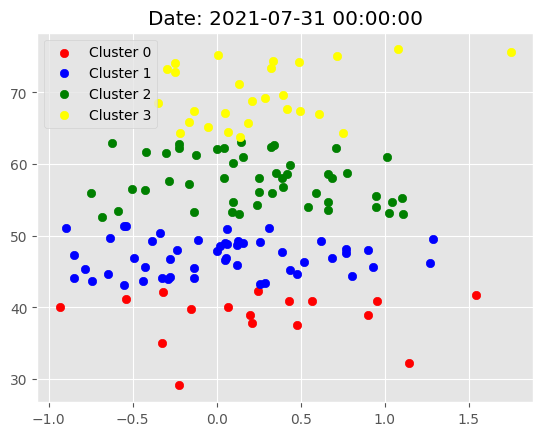

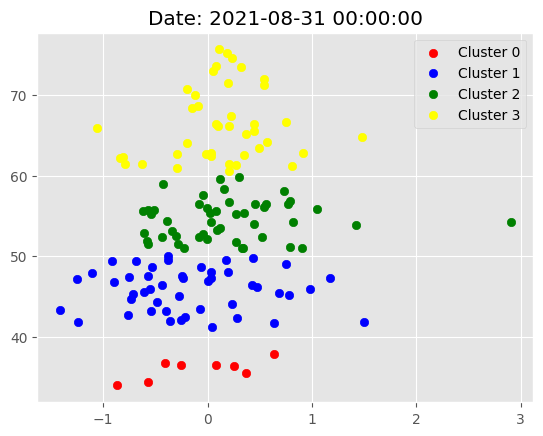

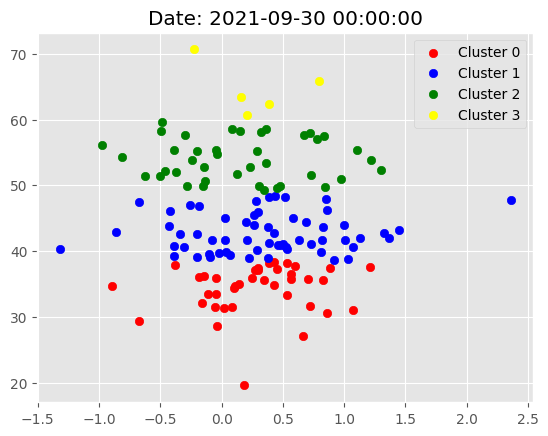

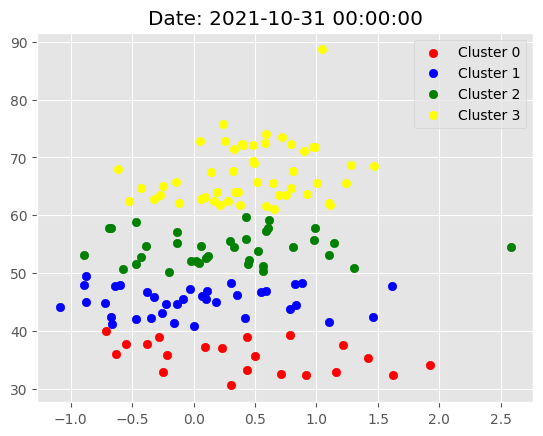

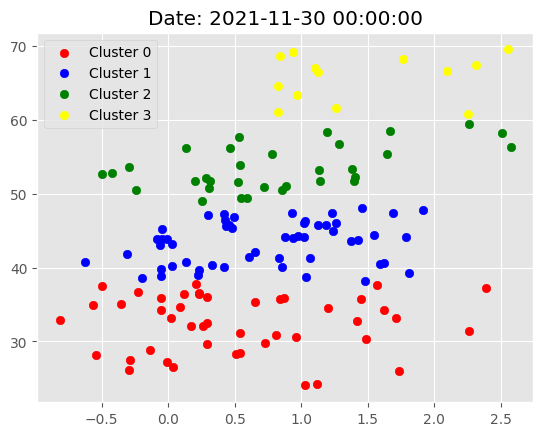

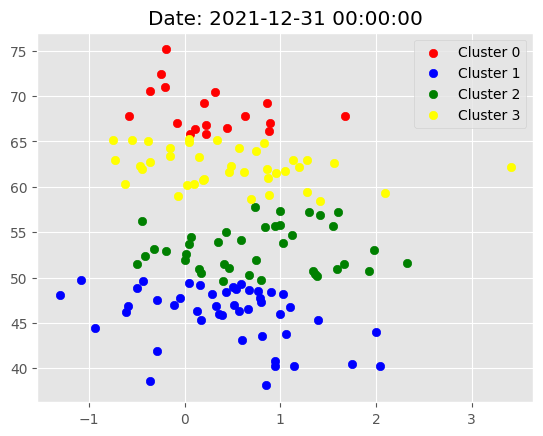

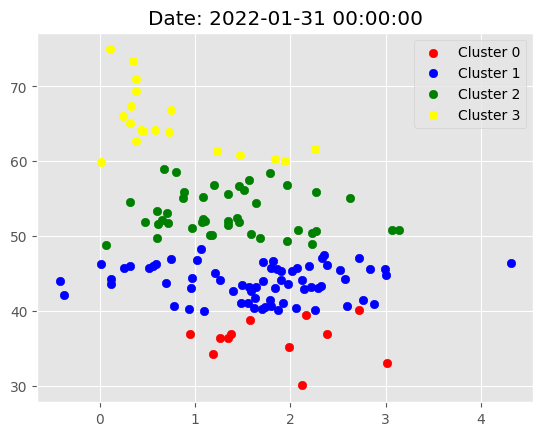

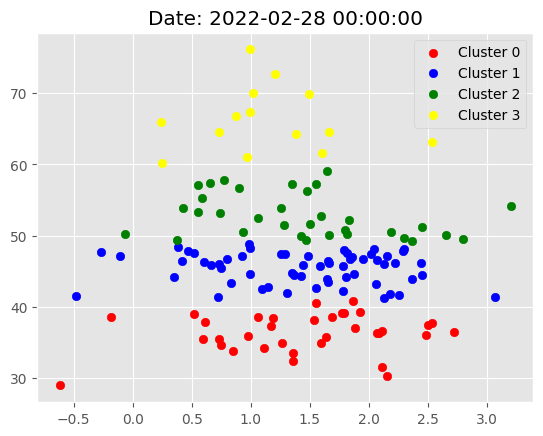

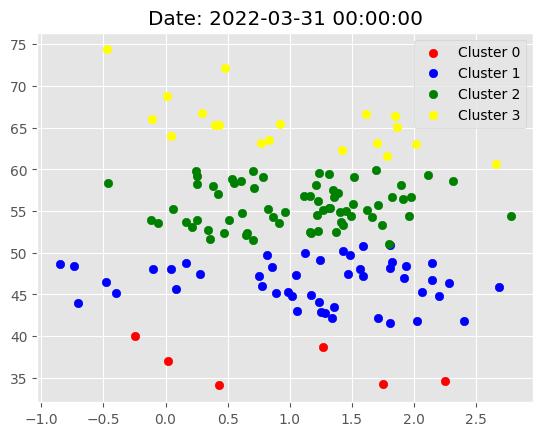

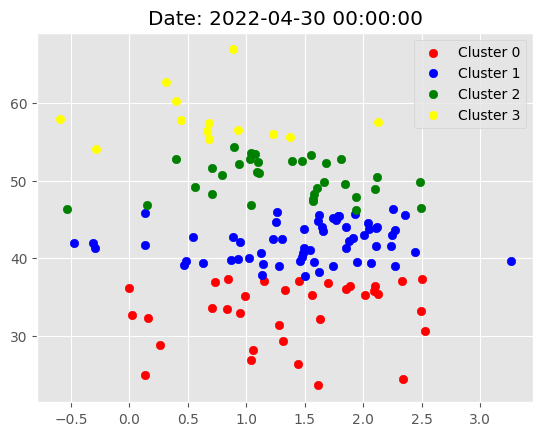

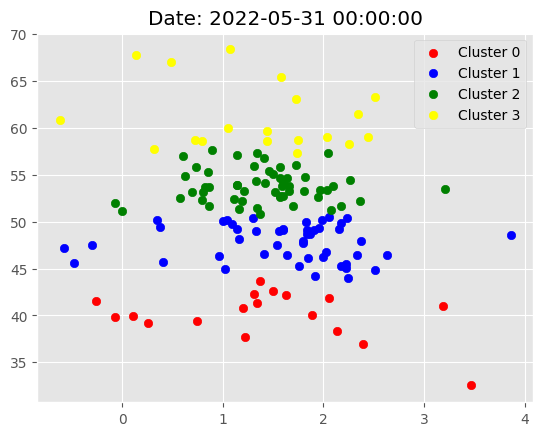

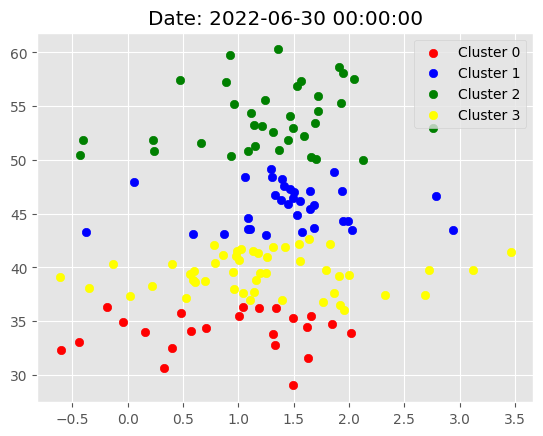

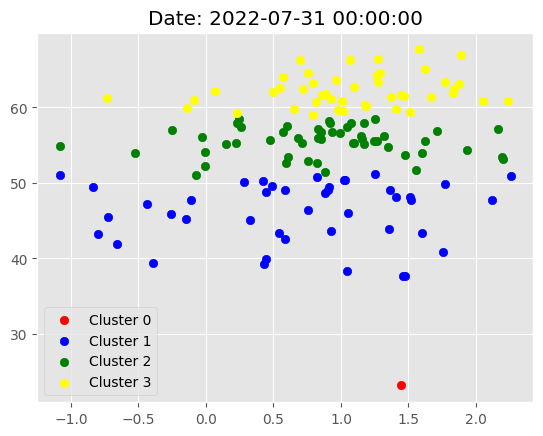

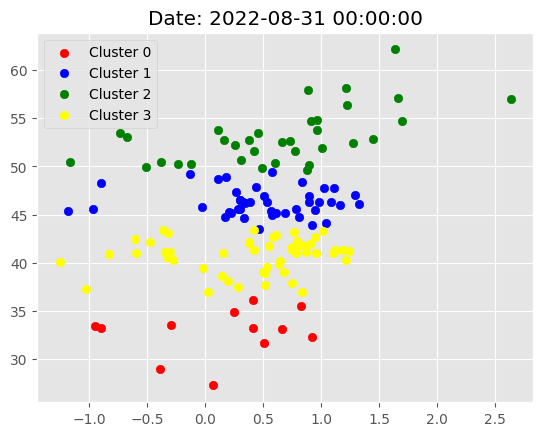

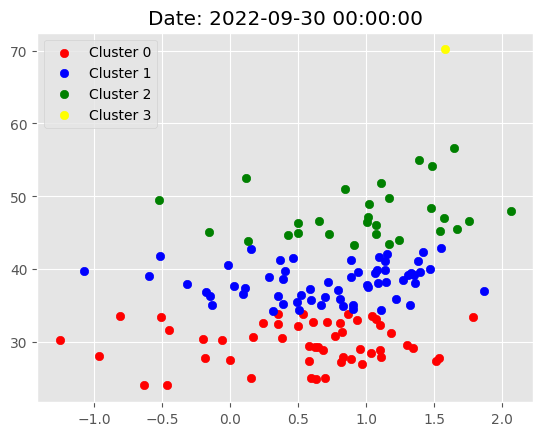

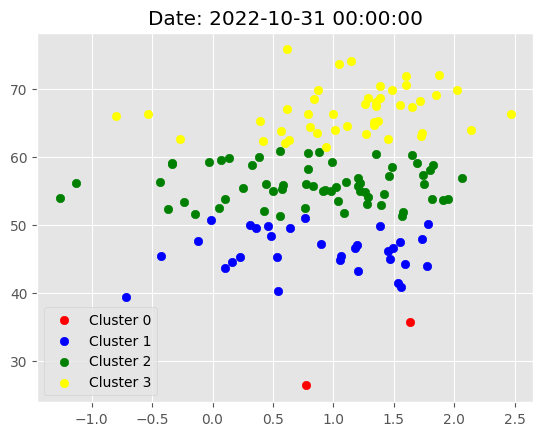

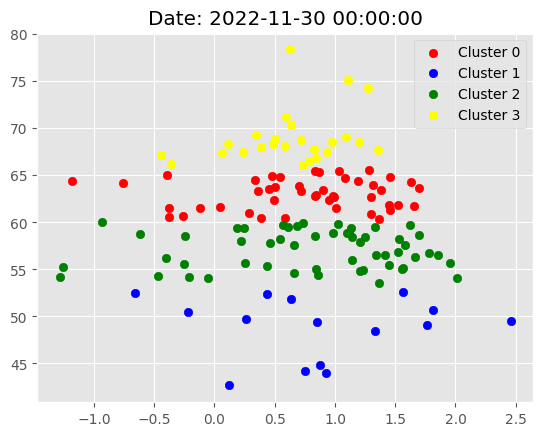

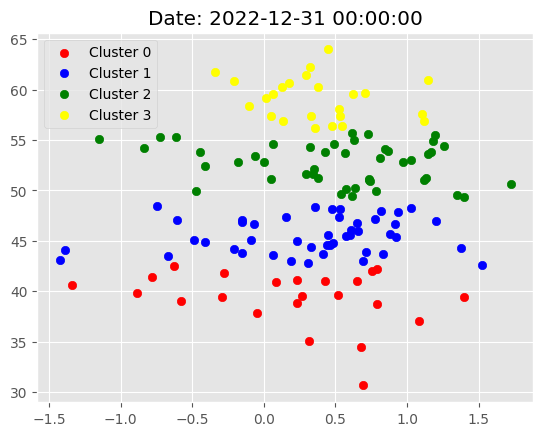

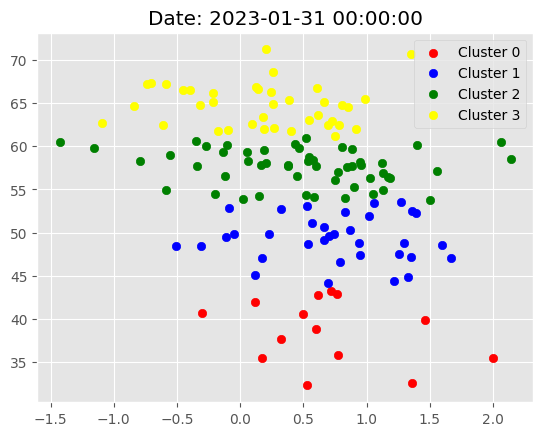

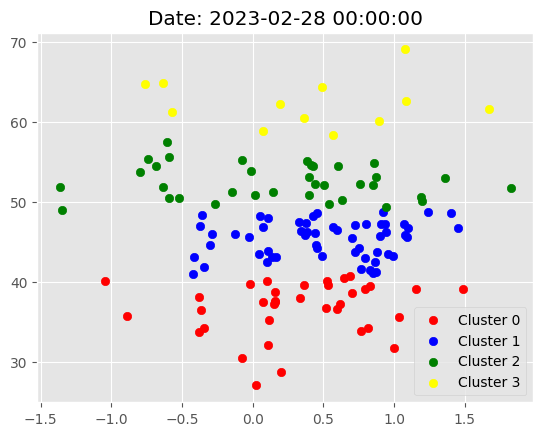

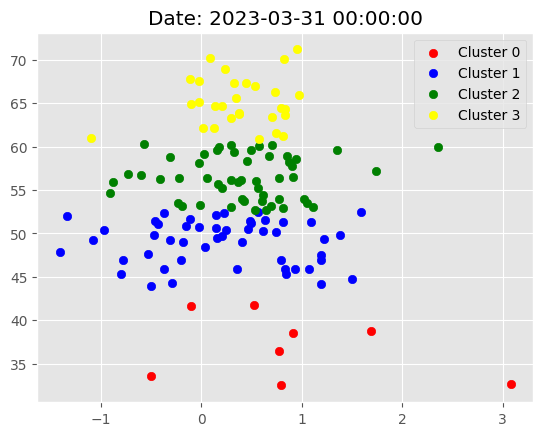

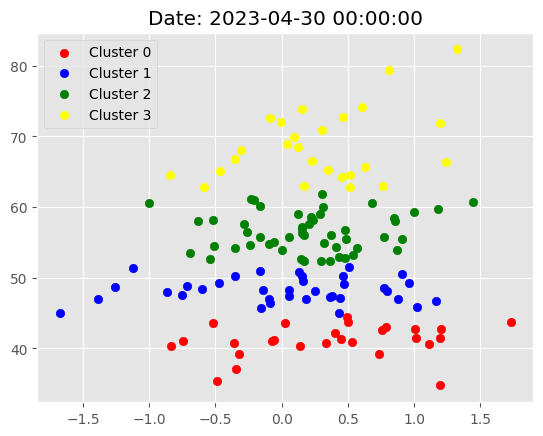

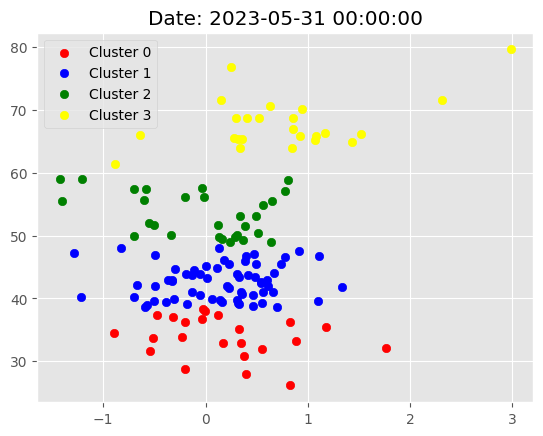

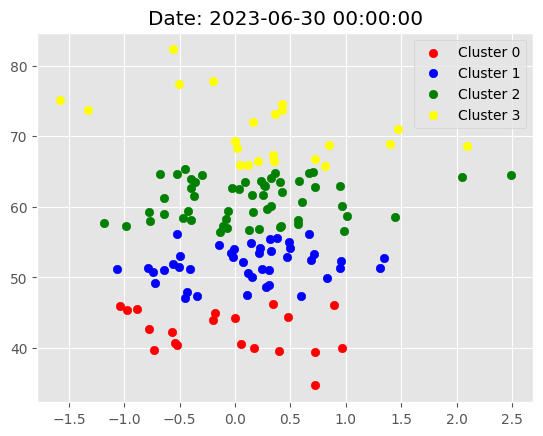

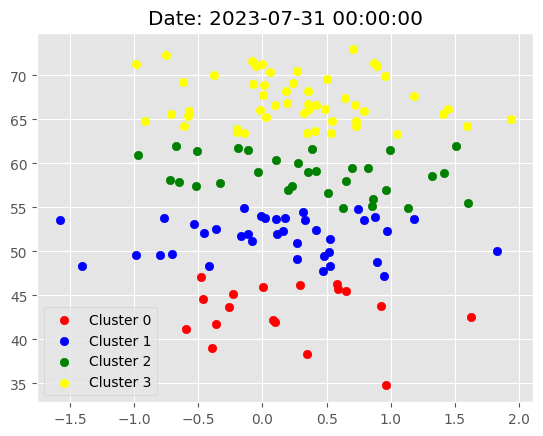

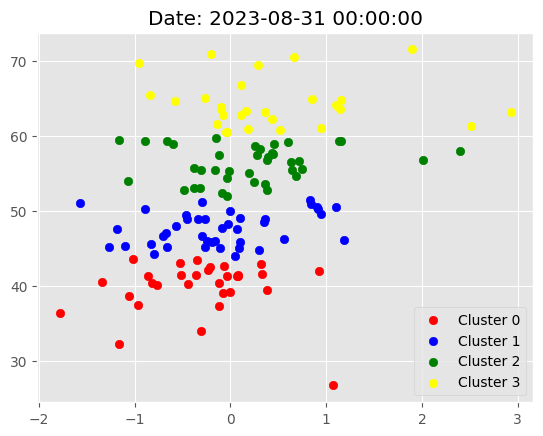

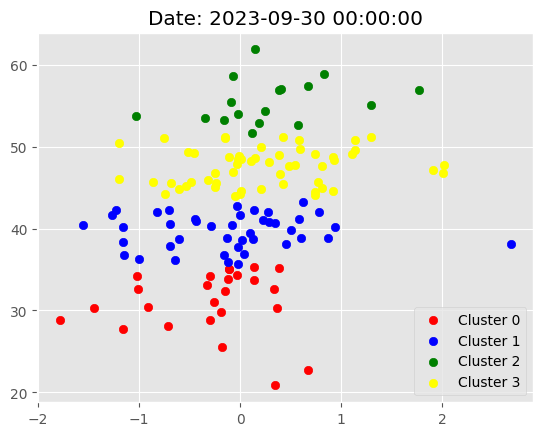

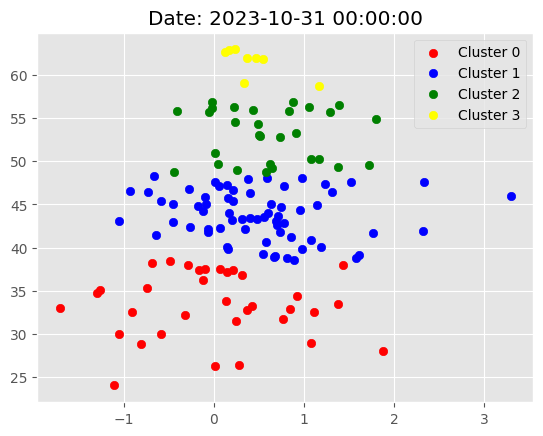

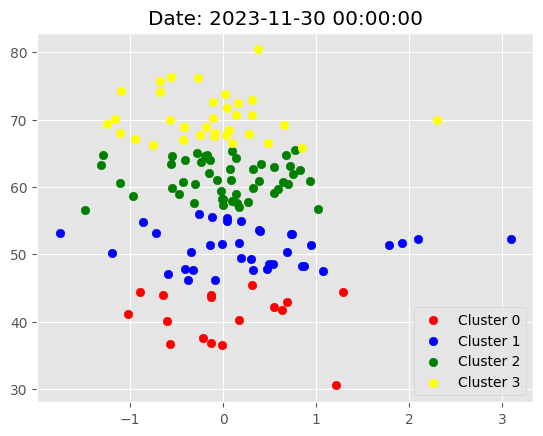

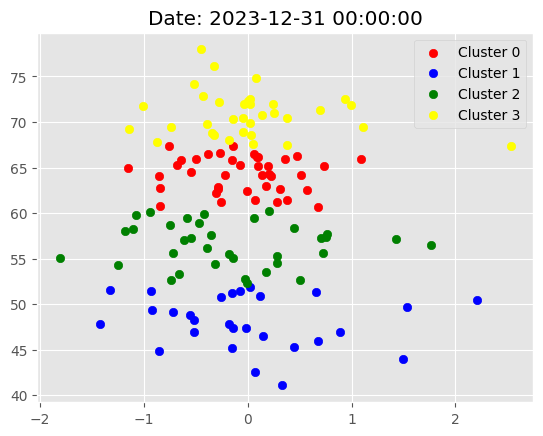

In [112]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i, level=0)
    plt.title(f'Date: {i}')
    plot_clusters(g)

In [109]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))
initial_centroids[:, 1] = target_rsi_values

initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [120]:
# filtered_df = data[data['cluster'] == 3].copy()
# filtered_df = filtered_df.reset_index(level=1)
# filtered_df.index = filtered_df.index + pd.DateOffset(1)
# filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])
dates = filtered_df.index.get_level_values('date').unique().tolist()
fixed_dates = {}
for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2018-02-01': ['ABT',
  'ADBE',
  'AMZN',
  'BA',
  'BAC',
  'BRK-B',
  'CHTR',
  'CRM',
  'CTSH',
  'DG',
  'EA',
  'GD',
  'GOOG',
  'GOOGL',
  'JPM',
  'KR',
  'LMT',
  'LOW',
  'MA',
  'MAR',
  'MSFT',
  'NFLX',
  'NKE',
  'NVDA',
  'NXPI',
  'PNC',
  'PYPL',
  'RTX',
  'TMO',
  'V',
  'WFC',
  'WMT'],
 '2018-03-01': ['AAPL',
  'ADBE',
  'AMZN',
  'BA',
  'BKNG',
  'CRM',
  'CSCO',
  'CTSH',
  'INTC',
  'MA',
  'MU',
  'NFLX',
  'NXPI',
  'PANW',
  'TJX'],
 '2018-04-01': ['AMT',
  'BKNG',
  'CL',
  'COP',
  'INTC',
  'NEE',
  'PANW',
  'STZ',
  'TJX',
  'WYNN'],
 '2018-05-01': ['CMG', 'COP', 'EOG', 'HAL', 'OXY', 'PXD', 'ULTA', 'VLO'],
 '2018-06-01': ['ADBE',
  'AMD',
  'AMZN',
  'BIIB',
  'CMG',
  'CSX',
  'EXPE',
  'GM',
  'LLY',
  'LOW',
  'META',
  'NEE',
  'NFLX',
  'OXY',
  'PANW',
  'TJX',
  'TXN',
  'VLO'],
 '2018-07-01': ['ACN',
  'AMT',
  'BSX',
  'COST',
  'CRM',
  'EA',
  'EOG',
  'KR',
  'MDLZ',
  'NEE',
  'NFLX',
  'NKE',
  'PARA',
  'PEP',
  'PG',
  'REGN',
  'SHW',


## Define portfolio optimization function

In [133]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound):
    returns = expected_returns.mean_historical_return(prices=prices)
    cov = risk_models.sample_cov(prices=prices)
    ef = EfficientFrontier(expected_returns=returns, cov_matrix=cov, weight_bounds=(lower_bound, .1), solver='SCS')
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

In [135]:
stocks = data.index.get_level_values('ticker').unique().tolist()
new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0] - pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])
new_df

[*********************100%%**********************]  156 of 156 completed


Adj Close                                                  \
                  AAL        AAPL        ABBV         ABT         ACN   
Date                                                                    
2017-01-31  42.760250   28.233551   44.951488   36.922539  101.850815   
2017-02-01  42.566978   29.955250   44.789669   37.417545  101.260475   
2017-02-02  42.528324   29.904060   44.789669   37.788811  101.645073   
2017-02-03  42.711933   30.032024   44.627838   37.815331  102.405373   
2017-02-06  43.774902   30.313545   44.613121   37.505951  102.128090   
...               ...         ...         ...         ...         ...   
2023-12-22  14.310000  193.600006  153.473663  108.505814  353.160400   
2023-12-26  14.110000  193.050003  153.156693  108.704857  352.144104   
2023-12-27  13.990000  193.149994  153.414230  109.262161  352.532684   
2023-12-28  13.980000  193.580002  153.285461  109.869232  350.310791   
2023-12-29  13.740000  192.529999  153.503372  109.540817  349.633270   

                                                                       ...  \
                  ADBE         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2017-01-31  113.379997   87.153664   81.339996  53.358711   31.547495  ...   
2017-02-01  113.360001   82.200073   81.279999  53.367012   32.265965  ...   
2017-02-02  113.160004   83.123474   82.760002  53.242447   32.183064  ...   
2017-02-03  115.169998   83.598129   84.410004  53.923359   32.523872  ...   
2017-02-06  114.459999   83.252930   82.820000  53.890148   32.404118  ...   
...                ...         ...         ...        ...         ...  ...   
2023-12-22  598.750000  230.970001  242.759995  66.930000  162.050003  ...   
2023-12-26  598.260010  232.539993  245.070007  67.129997  164.279999  ...   
2023-12-27  596.080017  231.610001  245.110001  67.150002  164.210007  ...   
2023-12-28  595.520020  232.490005  244.910004  67.870003  163.119995  ...   
2023-12-29  596.599976  232.970001  243.479996  67.750000  162.070007  ...   

              Volume                                                  \
                   V       VLO     VRTX        VZ       WBA      WDC   
Date                                                                   
2017-01-31   7479400  11657700  2418400  16844200   3424400  3617800   
2017-02-01   7534400   5204500  1754700  26004100   5080000  3897800   
2017-02-02  11142300   6193200  1290800  17787200   3667400  2982700   
2017-02-03  28079600   4416400  1226800  15166400   3167700  2624900   
2017-02-06   9665300   4297800  1423800  16151400   3418400  2307400   
...              ...       ...      ...       ...       ...      ...   
2023-12-22   5111500   2279000   804200  13157900   9776300  2936500   
2023-12-26   2085100   1807100   531600  11856600  10181100  2010800   
2023-12-27   4034700   1358000   594000  15267600   8265500  2167200   
2023-12-28   3020500   1661200   735600  14931700   7899900  4200000   
2023-12-29   4074600   1963400   727400  16205200  10853300  3478100   

                                                  
                 WFC      WMT     WYNN       XOM  
Date                                              
2017-01-31  22409100  9320900  1827500  19128100  
2017-02-01  21157700  9050000  3025400  15111800  
2017-02-02  13044400  8998700  1698700  12200100  
2017-02-03  19879800  7625300  1888800  12746300  
2017-02-06  13940200  9097200  2828800   9938200  
...              ...      ...      ...       ...  
2023-12-22  10448000  6467400  1170500  12921800  
2023-12-26   8856600  3893300  1150000  16835100  
2023-12-27  12536700  6632000  1142200  14558800  
2023-12-28   9872600  5592000  1233000  16329300  
2023-12-29  11731900  7314200  1144800  17741400  

[1741 rows x 936 columns]

### Calculate daily returns for each stock; loop over each month and select the stocks for the month and weights for the following month; calculate daily portfolio returns

In [184]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    try:
        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        cols = fixed_dates[start_date]
        
        optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df, lower_bound=round(1/(len(optimization_df.columns) * 2), 3))
            weights = pd.DataFrame(weights, index=pd.Series(0))
            success=True
        
        except:
            print(f'Max Sharpe Optimization Failed for {start_date}')
        
        if success == False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                   index=optimization_df.columns.tolist(),
                                   columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]
        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
            .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True), left_index=True, right_index=True)\
            .reset_index().set_index(['Date', 'index']).unstack().stack()
            
        temp_df.index.names = ['date', 'ticker']
        temp_df['weighted return'] = temp_df['return'] * temp_df['weight']
        temp_df = temp_df.groupby(level=0)['weighted return'].sum().to_frame('Strategy Return')
        
        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()
portfolio_df
    

Max Sharpe Optimization Failed for 2018-05-01
Max Sharpe Optimization Failed for 2020-03-01
Max Sharpe Optimization Failed for 2020-04-01
Max Sharpe Optimization Failed for 2021-02-01
Max Sharpe Optimization Failed for 2021-10-01
Max Sharpe Optimization Failed for 2022-09-01
Max Sharpe Optimization Failed for 2022-10-01
Max Sharpe Optimization Failed for 2023-11-01
'return'


,Strategy Return
date,
2018-02-01,-0.007096
2018-02-02,-0.017952
2018-02-05,-0.041640
2018-02-06,0.017543
2018-02-07,0.001828
...,...
2023-12-22,0.002407
2023-12-26,0.005684
2023-12-27,0.002800


# Visualize Portfolio Returns

In [187]:
spy = yf.download(tickers='SPY',
                  start='2016-01-01',
                  end=end_date)

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close': 'SPY Buy & Hold'}, axis=1)
spy_ret.index.names = ['date']
# print(portfolio_df.index)
# print(spy_ret.index)
# print(portfolio_df.index.dtype)
# print(spy_ret.index.dtype)
# print(portfolio_df.index[:5])
# print(spy_ret.index[:5])
# spy_ret
portfolio_df = portfolio_df.merge(spy_ret, left_index=True, right_index=True)
portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,SPY Buy & Hold
date,,
2018-02-01,-0.007096,-0.001136
2018-02-02,-0.017952,-0.022010
2018-02-05,-0.041640,-0.042722
2018-02-06,0.017543,0.019511
2018-02-07,0.001828,-0.005440
...,...,...
2023-12-22,0.002407,0.002008
2023-12-26,0.005684,0.004214
2023-12-27,0.002800,0.001806


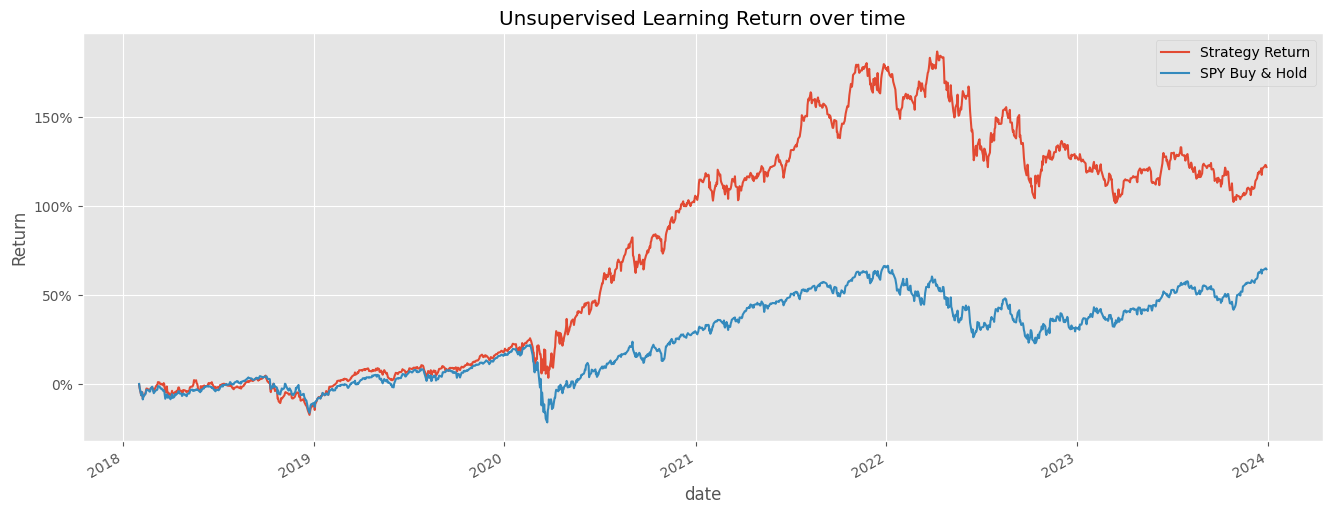

In [190]:
import matplotlib.ticker as mtick


plt.style.use('ggplot')
portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()) - 1
portfolio_cumulative_return[:'2023-12-29'].plot(figsize=(16,6))
plt.title('Unsupervised Learning Return over time')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Return')
plt.show()